In [16]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files


!conda install -c conda-forge geopy --yes
!pip install geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print("Libraries imported.")

# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

# All requested packages already installed.

Libraries imported.
Solving environment: done

# All requested packages already installed.

Wordcloud is installed and imported!


In [17]:
# initialize list of lists 
cities = [['Dunwoody', 'GA'], ['Sandy Springs', 'GA'], ['Roswell','GA'],['Woodstock','GA'],['Norcross','GA'],['Suwanee','GA'],['Alpharetta','GA'],['Marietta','GA'],['Duluth','GA']] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(cities, columns = ['City', 'State']) 
  
# print dataframe. 
df 

,City,State
0,Dunwoody,GA
1,Sandy Springs,GA
2,Roswell,GA
3,Woodstock,GA
4,Norcross,GA
5,Suwanee,GA
6,Alpharetta,GA
7,Marietta,GA
8,Duluth,GA


In [18]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, GA'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [19]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhood) for neighborhood in df["City"].tolist() ]

In [20]:
coords

[[33.92620000000005, -84.33617999999996],
 [33.92483000000004, -84.37907999999999],
 [34.021660000000054, -84.35929999999996],
 [34.102910000000065, -84.51874999999995],
 [33.942810000000065, -84.21094999999997],
 [34.05746000000005, -84.06474999999995],
 [34.07540000000006, -84.29454999999996],
 [33.95319000000006, -84.54587999999995],
 [34.003630000000044, -84.14536999999996]]

In [21]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [22]:
# merge the coordinates into the original dataframe
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

In [23]:
# check the neighborhoods and the coordinates
print(df.shape)
df

(9, 4)


,City,State,Latitude,Longitude
0,Dunwoody,GA,33.92620,-84.33618
1,Sandy Springs,GA,33.92483,-84.37908
2,Roswell,GA,34.02166,-84.35930
3,Woodstock,GA,34.10291,-84.51875
4,Norcross,GA,33.94281,-84.21095
5,Suwanee,GA,34.05746,-84.06475
6,Alpharetta,GA,34.07540,-84.29455
7,Marietta,GA,33.95319,-84.54588
8,Duluth,GA,34.00363,-84.14537


In [24]:
# get the coordinates of Roswell, GA
address = 'Roswell, GA'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Roswell, GA {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Roswell, GA 34.02332, -84.360022.


In [25]:
# create map of Atlanta Cities using Roswell latitude and longitude values as the center
map_atl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['City']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_atl)  
    
map_atl

In [26]:
# define Foursquare Credentials and Version
CLIENT_ID = 'MKIX5GO0RCMABWJ2HYMBTLBHAMHSPZLQTVSXOEH24SA5BHG4' # your Foursquare ID
CLIENT_SECRET = 'GNFV4N01EC4LK2EJEMVD25J2UNKCR3COGSBNZ4LWO30JFLVX' # your Foursquare Secret
VERSION = '20180602' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MKIX5GO0RCMABWJ2HYMBTLBHAMHSPZLQTVSXOEH24SA5BHG4
CLIENT_SECRET:GNFV4N01EC4LK2EJEMVD25J2UNKCR3COGSBNZ4LWO30JFLVX


In [27]:
radius = 2000
LIMIT = 100
CATEGORYID = '4d4b7105d754a06374d81259'

venues = []

for lat, long, neighborhood in zip(df['Latitude'], df['Longitude'], df['City']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId=4d4b7105d754a06374d81259".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT,
        CATEGORYID
    )
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [28]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['City', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head(10)

(525, 7)


,City,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Dunwoody,33.9262,-84.33618,Alon's Bakery & Market,33.924560,-84.336402,Bakery
1,Dunwoody,33.9262,-84.33618,The Capital Grille,33.926564,-84.340573,American Restaurant
2,Dunwoody,33.9262,-84.33618,Seasons 52,33.926519,-84.339795,New American Restaurant
3,Dunwoody,33.9262,-84.33618,McKendrick's Steak House,33.925110,-84.335980,Steakhouse
4,Dunwoody,33.9262,-84.33618,Eclipse di Luna,33.924995,-84.335298,Tapas Restaurant
5,Dunwoody,33.9262,-84.33618,Fogo de Chão,33.930973,-84.337048,Steakhouse
6,Dunwoody,33.9262,-84.33618,Corner Bakery Cafe,33.927961,-84.336716,Bakery
7,Dunwoody,33.9262,-84.33618,California Pizza Kitchen at Perimeter,33.928364,-84.337520,Pizza Place
8,Dunwoody,33.9262,-84.33618,Maggiano's Little Italy,33.923520,-84.340550,Italian Restaurant
9,Dunwoody,33.9262,-84.33618,Cafe Intermezzo,33.925109,-84.335703,Café


In [29]:
# get the coordinates of Roswell, GA
address = 'Roswell, GA'

geolocator = Nominatim(user_agent="my-application")
location_r = geolocator.geocode(address)
latitude_r = location.latitude
longitude_r = location.longitude
print('The geograpical coordinate of Roswell, GA {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Roswell, GA 34.02332, -84.360022.


In [30]:
# create map of Atlanta Cities using Roswell latitude and longitude values as the center
map_atl = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(venues_df['VenueLatitude'], venues_df['VenueLongitude'], venues_df['City']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_atl)  
    
map_atl

In [32]:
venues_df.head()


,City,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Dunwoody,33.9262,-84.33618,Alon's Bakery & Market,33.924560,-84.336402,Bakery
1,Dunwoody,33.9262,-84.33618,The Capital Grille,33.926564,-84.340573,American Restaurant
2,Dunwoody,33.9262,-84.33618,Seasons 52,33.926519,-84.339795,New American Restaurant
3,Dunwoody,33.9262,-84.33618,McKendrick's Steak House,33.925110,-84.335980,Steakhouse
4,Dunwoody,33.9262,-84.33618,Eclipse di Luna,33.924995,-84.335298,Tapas Restaurant


In [36]:
venues_stats= venues_df.groupby(["City"])
venues_stats.describe().head(10)

Latitude                                                        \
                 count      mean           std       min       25%       50%   
City                                                                           
Alpharetta        82.0  34.07540  7.149153e-14  34.07540  34.07540  34.07540   
Duluth            31.0  34.00363  7.222880e-15  34.00363  34.00363  34.00363   
Dunwoody          73.0  33.92620  7.154600e-15  33.92620  33.92620  33.92620   
Marietta          71.0  33.95319  6.440400e-14  33.95319  33.95319  33.95319   
Norcross          33.0  33.94281  2.886238e-14  33.94281  33.94281  33.94281   
Roswell           67.0  34.02166  2.147716e-14  34.02166  34.02166  34.02166   
Sandy Springs     80.0  33.92483  7.150257e-14  33.92483  33.92483  33.92483   
Suwanee           39.0  34.05746  3.599156e-14  34.05746  34.05746  34.05746   
Woodstock         49.0  34.10291  0.000000e+00  34.10291  34.10291  34.10291   

                                  Longitude                                    \
                    75%       max     count      mean           std       min   
City                                                                            
Alpharetta     34.07540  34.07540      82.0 -84.29455  8.578984e-14 -84.29455   
Duluth         34.00363  34.00363      31.0 -84.14537  5.778304e-14 -84.14537   
Dunwoody       33.92620  33.92620      73.0 -84.33618  4.292760e-14 -84.33618   
Marietta       33.95319  33.95319      71.0 -84.54588  4.293600e-14 -84.54588   
Norcross       33.94281  33.94281      33.0 -84.21095  1.443119e-14 -84.21095   
Roswell        34.02166  34.02166      67.0 -84.35930  8.590865e-14 -84.35930   
Sandy Springs  33.92483  33.92483      80.0 -84.37908  7.150257e-14 -84.37908   
Suwanee        34.05746  34.05746      39.0 -84.06475  4.318988e-14 -84.06475   
Woodstock      34.10291  34.10291      49.0 -84.51875  1.148650e-13 -84.51875   

                                                      VenueLatitude  \
                    25%       50%       75%       max         count   
City                                                                  
Alpharetta    -84.29455 -84.29455 -84.29455 -84.29455          82.0   
Duluth        -84.14537 -84.14537 -84.14537 -84.14537          31.0   
Dunwoody      -84.33618 -84.33618 -84.33618 -84.33618          73.0   
Marietta      -84.54588 -84.54588 -84.54588 -84.54588          71.0   
Norcross      -84.21095 -84.21095 -84.21095 -84.21095          33.0   
Roswell       -84.35930 -84.35930 -84.35930 -84.35930          67.0   
Sandy Springs -84.37908 -84.37908 -84.37908 -84.37908          80.0   
Suwanee       -84.06475 -84.06475 -84.06475 -84.06475          39.0   
Woodstock     -84.51875 -84.51875 -84.51875 -84.51875          49.0   

                                                                     \
                    mean       std        min        25%        50%   
City                                                                  
Alpharetta     34.071584  0.005566  34.057700  34.069128  34.070877   
Duluth         34.002748  0.003682  33.993751  34.000528  34.002993   
Dunwoody       33.927395  0.006356  33.913414  33.922744  33.927961   
Marietta       33.953267  0.009202  33.937341  33.946486  33.952181   
Norcross       33.943130  0.008994  33.929501  33.932850  33.942476   
Roswell        34.025979  0.006767  34.005195  34.023761  34.026526   
Sandy Springs  33.921887  0.009439  33.907425  33.915963  33.919402   
Suwanee        34.057762  0.008512  34.042420  34.054653  34.057389   
Woodstock      34.093862  0.007579  34.084994  34.086823  34.095196   

                                    VenueLongitude                       \
                     75%        max          count       mean       std   
City                                                                      
Alpharetta     34.074592  34.091099           82.0 -84.289466  0.010370   
Duluth         34.003704  34.008978           31.0 -84.142793  0.007560   

In [37]:
venues_subcount= venues_df.groupby(["City","VenueCategory"]).count()
venues_subcount.head(40)


Latitude  Longitude  VenueName  \
City       VenueCategory                                               
Alpharetta American Restaurant               8          8          8   
           BBQ Joint                         1          1          1   
           Bagel Shop                        3          3          3   
           Breakfast Spot                    3          3          3   
           Burger Joint                      2          2          2   
           Café                              2          2          2   
           Cajun / Creole Restaurant         1          1          1   
           Deli / Bodega                     3          3          3   
           Donut Shop                        1          1          1   
           Falafel Restaurant                1          1          1   
           Fast Food Restaurant              4          4          4   
           Food                              2          2          2   
           Food Truck                        1          1          1   
           French Restaurant                 1          1          1   
           Fried Chicken Joint               1          1          1   
           Gastropub                         1          1          1   
           German Restaurant                 1          1          1   
           Greek Restaurant                  1          1          1   
           Indian Restaurant                 3          3          3   
           Italian Restaurant                3          3          3   
           Japanese Restaurant               3          3          3   
           Mediterranean Restaurant          1          1          1   
           Mexican Restaurant                3          3          3   
           Middle Eastern Restaurant         1          1          1   
           New American Restaurant           6          6          6   
           North Indian Restaurant           1          1          1   
           Pizza Place                       5          5          5   
           Poke Place                        1          1          1   
           Restaurant                        4          4          4   
           Salad Place                       1          1          1   
           Sandwich Place                    2          2          2   
           Seafood Restaurant                1          1          1   
           Steakhouse                        2          2          2   
           Sushi Restaurant                  1          1          1   
           Taco Place                        3          3          3   
           Tapas Restaurant                  1          1          1   
           Tex-Mex Restaurant                1          1          1   
           Thai Restaurant                   1          1          1   
           Vietnamese Restaurant             1          1          1   
Duluth     American Restaurant               1          1          1   

                                      VenueLatitude  VenueLongitude  
City       VenueCategory                                             
Alpharetta American Restaurant                    8               8  
           BBQ Joint                              1               1  
           Bagel Shop                             3               3  
           Breakfast Spot                         3               3  
           Burger Joint                           2               2  
           Café                                   2               2  
           Cajun / Creole Restaurant              1               1  
           Deli / Bodega                          3               3  
           Donut Shop                             1               1  
           Falafel Restaurant                     1               1  
           Fast Food Restaurant                   4               4  
           Food                                   2               2  
           Food Truck            

In [54]:
venues_sum= venues_subcount.groupby(['City']).count()
venues_sum.head(20)

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude
City,,,,,
Alpharetta,39,39,39,39,39
Duluth,16,16,16,16,16
Dunwoody,33,33,33,33,33
Marietta,29,29,29,29,29
Norcross,21,21,21,21,21
Roswell,32,32,32,32,32
Sandy Springs,38,38,38,38,38
Suwanee,21,21,21,21,21
Woodstock,25,25,25,25,25


In [43]:
import matplotlib.pyplot as plt

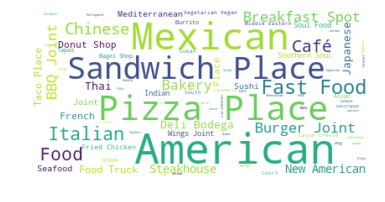

In [77]:
stop_words= ["Restaurant"]

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stop_words,max_font_size=50, max_words=100, background_color="white").generate(' '.join(venues_df['VenueCategory']))


# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [39]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'plt' is not defined

In [81]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 67 uniques categories.


In [82]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:75]

array(['Bakery', 'American Restaurant', 'New American Restaurant',
       'Tapas Restaurant', 'Steakhouse', 'Pizza Place',
       'Italian Restaurant', 'Café', 'Sandwich Place', 'Deli / Bodega',
       'Donut Shop', 'Burger Joint', 'Breakfast Spot',
       'Mexican Restaurant', 'Sushi Restaurant', 'Fast Food Restaurant',
       'Taco Place', 'French Restaurant', 'Indian Restaurant',
       'Mediterranean Restaurant', 'Hawaiian Restaurant',
       'Asian Restaurant', 'BBQ Joint', 'Chinese Restaurant',
       'Japanese Restaurant', 'Food Truck', 'Burrito Place',
       'Wings Joint', 'Buffet', 'Food Court', 'Tex-Mex Restaurant',
       'Restaurant', 'Cafeteria', 'Middle Eastern Restaurant',
       'Ramen Restaurant', 'Noodle House',
       'Vegetarian / Vegan Restaurant', 'Latin American Restaurant',
       'Hot Dog Joint', 'Greek Restaurant', 'Caribbean Restaurant',
       'Thai Restaurant', 'Fried Chicken Joint', 'Korean Restaurant',
       'South American Restaurant', 'Food', 'Snack P

In [83]:
# one hot encoding
atl_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add City column back to dataframe
atl_onehot['Cities'] = venues_df['City'] 

# move City column to the first column
fixed_columns = [atl_onehot.columns[-1]] + list(atl_onehot.columns[:-1])
atl_onehot = atl_onehot[fixed_columns]

print(atl_onehot.shape)
atl_onehot.head(20)

(524, 68)


,Cities,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Dunwoody,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dunwoody,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dunwoody,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dunwoody,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,Dunwoody,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,Dunwoody,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,Dunwoody,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Dunwoody,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Dunwoody,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Dunwoody,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [84]:
atl_grouped = atl_onehot.groupby(["Cities"]).mean().reset_index()

print(atl_grouped.shape)
atl_grouped

(9, 68)


,Cities,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Alpharetta,0.097561,0.000000,0.000000,0.012195,0.036585,0.000000,0.036585,0.000000,0.024390,0.000000,0.000000,0.024390,0.012195,0.000000,0.000000,0.000000,0.000000,0.036585,0.000000,0.012195,0.000000,0.000000,0.012195,0.048780,0.024390,0.000000,0.012195,0.012195,0.012195,0.012195,0.012195,0.012195,0.000000,0.000000,0.036585,0.000000,0.036585,0.036585,0.0000,0.0000,0.012195,0.036585,0.012195,0.073171,0.0000,0.012195,0.060976,0.012195,0.000000,0.0000,0.048780,0.012195,0.024390,0.012195,0.000000,0.000000,0.000000,0.024390,0.012195,0.036585,0.012195,0.012195,0.012195,0.000000,0.000000,0.012195,0.000000
1,Duluth,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0000,0.000000,0.096774,0.000000,0.000000,0.0000,0.000000,0.096774,0.000000,0.000000,0.0000,0.161290,0.000000,0.032258,0.000000,0.000000,0.000000,0.064516,0.032258,0.000000,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000
2,Dunwoody,0.123288,0.000000,0.013699,0.027397,0.000000,0.054795,0.027397,0.013699,0.041096,0.013699,0.013699,0.054795,0.000000,0.000000,0.013699,0.000000,0.000000,0.041096,0.000000,0.013699,0.000000,0.000000,0.000000,0.054795,0.000000,0.013699,0.027397,0.013699,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.013699,0.000000,0.041096,0.013699,0.0000,0.0000,0.027397,0.041096,0.000000,0.013699,0.0000,0.000000,0.068493,0.000000,0.000000,0.0000,0.027397,0.000000,0.041096,0.000000,0.000000,0.000000,0.000000,0.054795,0.013699,0.013699,0.013699,0.013699,0.000000,0.000000,0.000000,0.000000,0.027397
3,Marietta,0.100000,0.000000,0.014286,0.028571,0.000000,0.071429,0.000000,0.000000,0.028571,0.028571,0.000000,0.057143,0.000000,0.000000,0.028571,0.000000,0.000000,0.014286,0.000000,0.014286,0.000000,0.000000,0.000000,0.042857,0.028571,0.014286,0.000000,0.042857,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000,0.014286,0.014286,0.000000,0.0000,0.0000,0.014286,0.071429,0.000000,0.000000,0.0000,0.000000,0.057143,0.000000,0.000000,0.0000,0.085714,0.000000,0.085714,0.014286,0.000000,0.014286,0.028571,0.000000,0.000000,0.014286,0.014286,0.000000,0.014286,0.000000,0.000000,0.000000,0.000000
4,Norcross,0.060606,0.030303,0.000000,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.030303,0.030303,0.000000,0.030303,0.000000,0.030303,0.000000,0.030303,0.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.0000,0.0000,0.000000,0.121212,0.000000,0.000000,0.0000,0.000000,0.060606,0.000000,0.00000

In [85]:
# set number of clusters
kclusters = 6

atl_clustering = atl_grouped.drop(["Cities"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(atl_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 0, 4, 2, 4, 4, 1, 5], dtype=int32)

In [86]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
atl_merged = atl_grouped.copy()

# add clustering labels
atl_merged["Cluster Labels"] = kmeans.labels_



In [87]:
atl_merged.rename(columns={"Cities": "City"}, inplace=True)
atl_merged.head()

,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster Labels
0,Alpharetta,0.097561,0.000000,0.000000,0.012195,0.036585,0.000000,0.036585,0.000000,0.024390,0.000000,0.000000,0.024390,0.012195,0.000000,0.000000,0.000000,0.000000,0.036585,0.0,0.012195,0.0,0.000000,0.012195,0.048780,0.024390,0.000000,0.012195,0.012195,0.012195,0.012195,0.012195,0.012195,0.000000,0.000000,0.036585,0.000000,0.036585,0.036585,0.0,0.0,0.012195,0.036585,0.012195,0.073171,0.0,0.012195,0.060976,0.012195,0.0,0.0,0.048780,0.012195,0.024390,0.012195,0.0,0.000000,0.000000,0.024390,0.012195,0.036585,0.012195,0.012195,0.012195,0.0,0.0,0.012195,0.000000,0
1,Duluth,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.0,0.064516,0.0,0.000000,0.000000,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.096774,0.000000,0.000000,0.0,0.000000,0.096774,0.000000,0.0,0.0,0.161290,0.000000,0.032258,0.000000,0.0,0.000000,0.064516,0.032258,0.000000,0.000000,0.000000,0.000000,0.064516,0.0,0.0,0.000000,0.000000,3
2,Dunwoody,0.123288,0.000000,0.013699,0.027397,0.000000,0.054795,0.027397,0.013699,0.041096,0.013699,0.013699,0.054795,0.000000,0.000000,0.013699,0.000000,0.000000,0.041096,0.0,0.013699,0.0,0.000000,0.000000,0.054795,0.000000,0.013699,0.027397,0.013699,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.013699,0.000000,0.041096,0.013699,0.0,0.0,0.027397,0.041096,0.000000,0.013699,0.0,0.000000,0.068493,0.000000,0.0,0.0,0.027397,0.000000,0.041096,0.000000,0.0,0.000000,0.000000,0.054795,0.013699,0.013699,0.013699,0.013699,0.000000,0.0,0.0,0.000000,0.027397,0
3,Marietta,0.100000,0.000000,0.014286,0.028571,0.000000,0.071429,0.000000,0.000000,0.028571,0.028571,0.000000,0.057143,0.000000,0.000000,0.028571,0.000000,0.000000,0.014286,0.0,0.014286,0.0,0.000000,0.000000,0.042857,0.028571,0.014286,0.000000,0.042857,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000,0.014286,0.014286,0.000000,0.0,0.0,0.014286,0.071429,0.000000,0.000000,0.0,0.000000,0.057143,0.000000,0.0,0.0,0.085714,0.000000,0.085714,0.014286,0.0,0.014286,0.028571,0.000000,0.000000,0.014286,0.014286,0.000000,0.014286,0.0,0.0,0.000000,0.000000,4
4,Norcross,0.060606,0.030303,0.000000,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.030303,0.030303,0.0,0.030303,0.0,0.030303,0.000000,0.030303,0.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.0,0.0,0.000000,0.121212,0.000000,0.000000,0.0,0.000000,0.060606,0.000000,0.0,0.0,0.030303,0.000000,0.060606,0.000000,0.0,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,0.0,0.0,0.000000,0.060606,2


In [88]:
# merge atlanta_grouped with atlanta_data to add latitude/longitude for each neighborhood
atl_merged = atl_merged.join(df.set_index("City"), on="City")

print(atl_merged.shape)
atl_merged.head() # check the last columns!

(9, 72)


,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster Labels,State,Latitude,Longitude
0,Alpharetta,0.097561,0.000000,0.000000,0.012195,0.036585,0.000000,0.036585,0.000000,0.024390,0.000000,0.000000,0.024390,0.012195,0.000000,0.000000,0.000000,0.000000,0.036585,0.0,0.012195,0.0,0.000000,0.012195,0.048780,0.024390,0.000000,0.012195,0.012195,0.012195,0.012195,0.012195,0.012195,0.000000,0.000000,0.036585,0.000000,0.036585,0.036585,0.0,0.0,0.012195,0.036585,0.012195,0.073171,0.0,0.012195,0.060976,0.012195,0.0,0.0,0.048780,0.012195,0.024390,0.012195,0.0,0.000000,0.000000,0.024390,0.012195,0.036585,0.012195,0.012195,0.012195,0.0,0.0,0.012195,0.000000,0,GA,34.07540,-84.29455
1,Duluth,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.0,0.064516,0.0,0.000000,0.000000,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.096774,0.000000,0.000000,0.0,0.000000,0.096774,0.000000,0.0,0.0,0.161290,0.000000,0.032258,0.000000,0.0,0.000000,0.064516,0.032258,0.000000,0.000000,0.000000,0.000000,0.064516,0.0,0.0,0.000000,0.000000,3,GA,34.00363,-84.14537
2,Dunwoody,0.123288,0.000000,0.013699,0.027397,0.000000,0.054795,0.027397,0.013699,0.041096,0.013699,0.013699,0.054795,0.000000,0.000000,0.013699,0.000000,0.000000,0.041096,0.0,0.013699,0.0,0.000000,0.000000,0.054795,0.000000,0.013699,0.027397,0.013699,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.013699,0.000000,0.041096,0.013699,0.0,0.0,0.027397,0.041096,0.000000,0.013699,0.0,0.000000,0.068493,0.000000,0.0,0.0,0.027397,0.000000,0.041096,0.000000,0.0,0.000000,0.000000,0.054795,0.013699,0.013699,0.013699,0.013699,0.000000,0.0,0.0,0.000000,0.027397,0,GA,33.92620,-84.33618
3,Marietta,0.100000,0.000000,0.014286,0.028571,0.000000,0.071429,0.000000,0.000000,0.028571,0.028571,0.000000,0.057143,0.000000,0.000000,0.028571,0.000000,0.000000,0.014286,0.0,0.014286,0.0,0.000000,0.000000,0.042857,0.028571,0.014286,0.000000,0.042857,0.028571,0.000000,0.000000,0.000000,0.000000,0.014286,0.000000,0.014286,0.014286,0.000000,0.0,0.0,0.014286,0.071429,0.000000,0.000000,0.0,0.000000,0.057143,0.000000,0.0,0.0,0.085714,0.000000,0.085714,0.014286,0.0,0.014286,0.028571,0.000000,0.000000,0.014286,0.014286,0.000000,0.014286,0.0,0.0,0.000000,0.000000,4,GA,33.95319,-84.54588
4,Norcross,0.060606,0.030303,0.000000,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.030303,0.030303,0.0,0.030303,0.0,0.030303,0.000000,0.030303,0.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.0,0.0,0.000000,0.121212,0.000000,0.000000,0.0,0.000000,0.060606,0.000000,0.0,0.0,0.030303,0.000000,0.060606,0.000000,0.0,0.030303,0.0

In [89]:
# sort the results by Cluster Labels
print(atl_merged.shape)
atl_merged.sort_values(["Cluster Labels"], inplace=True)
atl_merged



(9, 72)


,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster Labels,State,Latitude,Longitude
0,Alpharetta,0.097561,0.000000,0.000000,0.012195,0.036585,0.000000,0.036585,0.000000,0.024390,0.000000,0.000000,0.024390,0.012195,0.000000,0.000000,0.000000,0.000000,0.036585,0.000000,0.012195,0.000000,0.000000,0.012195,0.048780,0.024390,0.000000,0.012195,0.012195,0.012195,0.012195,0.012195,0.012195,0.000000,0.000000,0.036585,0.000000,0.036585,0.036585,0.0000,0.0000,0.012195,0.036585,0.012195,0.073171,0.0000,0.012195,0.060976,0.012195,0.000000,0.0000,0.048780,0.012195,0.024390,0.012195,0.000000,0.000000,0.000000,0.024390,0.012195,0.036585,0.012195,0.012195,0.012195,0.000000,0.000000,0.012195,0.000000,0,GA,34.07540,-84.29455
2,Dunwoody,0.123288,0.000000,0.013699,0.027397,0.000000,0.054795,0.027397,0.013699,0.041096,0.013699,0.013699,0.054795,0.000000,0.000000,0.013699,0.000000,0.000000,0.041096,0.000000,0.013699,0.000000,0.000000,0.000000,0.054795,0.000000,0.013699,0.027397,0.013699,0.000000,0.000000,0.000000,0.000000,0.013699,0.000000,0.013699,0.000000,0.041096,0.013699,0.0000,0.0000,0.027397,0.041096,0.000000,0.013699,0.0000,0.000000,0.068493,0.000000,0.000000,0.0000,0.027397,0.000000,0.041096,0.000000,0.000000,0.000000,0.000000,0.054795,0.013699,0.013699,0.013699,0.013699,0.000000,0.000000,0.000000,0.000000,0.027397,0,GA,33.92620,-84.33618
7,Suwanee,0.076923,0.000000,0.000000,0.025641,0.000000,0.025641,0.051282,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.102564,0.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.076923,0.051282,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051282,0.025641,0.0000,0.0000,0.000000,0.102564,0.000000,0.000000,0.0000,0.000000,0.102564,0.000000,0.000000,0.0000,0.051282,0.000000,0.025641,0.025641,0.025641,0.000000,0.000000,0.000000,0.051282,0.025641,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,1,GA,34.05746,-84.06475
4,Norcross,0.060606,0.030303,0.000000,0.030303,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.030303,0.030303,0.030303,0.000000,0.030303,0.000000,0.030303,0.000000,0.030303,0.151515,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.0000,0.0000,0.000000,0.121212,0.000000,0.000000,0.0000,0.000000,0.060606,0.000000,0.000000,0.0000,0.030303,0.000000,0.060606,0.000000,0.000000,0.030303,0.000000,0.030303,0.000000,0.000000,0.000000,0.000000,0.030303,0.000000,0.000000,0.000000,0.060606,2,GA,33.94281,-84.21095
1,Duluth,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.064516,0.000000,0.000000,0.064516,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [90]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(atl_merged['VenueLatitude'], atl_merged['VenueLongitude'], atl_merged['City'], atl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

KeyError: 'VenueLatitude'

In [60]:
atl_merged.loc[atl_merged['Cluster Labels'] == 0]

,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster Labels,State,Latitude,Longitude
0,Alpharetta,0.097561,0.0,0.000000,0.012195,0.036585,0.000000,0.036585,0.000000,0.024390,0.000000,0.000000,0.024390,0.012195,0.0,0.000000,0.0,0.0,0.036585,0.0,0.012195,0.0,0.0,0.012195,0.048780,0.02439,0.000000,0.012195,0.012195,0.012195,0.012195,0.012195,0.012195,0.000000,0.0,0.036585,0.0,0.036585,0.036585,0.0,0.0,0.012195,0.036585,0.012195,0.073171,0.0,0.012195,0.060976,0.012195,0.0,0.0,0.048780,0.012195,0.024390,0.012195,0.0,0.0,0.0,0.024390,0.012195,0.036585,0.012195,0.012195,0.012195,0.0,0.0,0.012195,0.000000,0,GA,34.0754,-84.29455
2,Dunwoody,0.123288,0.0,0.013699,0.027397,0.000000,0.054795,0.027397,0.013699,0.041096,0.013699,0.013699,0.054795,0.000000,0.0,0.013699,0.0,0.0,0.041096,0.0,0.013699,0.0,0.0,0.000000,0.054795,0.00000,0.013699,0.027397,0.013699,0.000000,0.000000,0.000000,0.000000,0.013699,0.0,0.013699,0.0,0.041096,0.013699,0.0,0.0,0.027397,0.041096,0.000000,0.013699,0.0,0.000000,0.068493,0.000000,0.0,0.0,0.027397,0.000000,0.041096,0.000000,0.0,0.0,0.0,0.054795,0.013699,0.013699,0.013699,0.013699,0.000000,0.0,0.0,0.000000,0.027397,0,GA,33.9262,-84.33618


In [61]:
atl_merged.loc[atl_merged['Cluster Labels'] == 1]

,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster Labels,State,Latitude,Longitude
7,Suwanee,0.076923,0.0,0.0,0.025641,0.0,0.025641,0.051282,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.102564,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.076923,0.051282,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.051282,0.025641,0.0,0.0,0.0,0.102564,0.0,0.0,0.0,0.0,0.102564,0.0,0.0,0.0,0.051282,0.0,0.025641,0.025641,0.025641,0.0,0.0,0.0,0.051282,0.025641,0.0,0.0,0.025641,0.0,0.0,0.0,0.0,1,GA,34.05746,-84.06475


In [62]:
atl_merged.loc[atl_merged['Cluster Labels'] == 2]

,City,American Restaurant,Arepa Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Breakfast Spot,Buffet,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Deli / Bodega,Diner,Donut Shop,Eastern European Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Greek Restaurant,Hawaiian Restaurant,Hot Dog Joint,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Pizza Place,Poke Place,Portuguese Restaurant,Ramen Restaurant,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,South American Restaurant,Southern / Soul Food Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster Labels,State,Latitude,Longitude
4,Norcross,0.060606,0.030303,0.0,0.030303,0.0,0.0,0.060606,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.030303,0.030303,0.030303,0.0,0.030303,0.0,0.030303,0.0,0.030303,0.151515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.121212,0.0,0.0,0.0,0.0,0.060606,0.0,0.0,0.0,0.030303,0.0,0.060606,0.0,0.0,0.030303,0.0,0.030303,0.0,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.060606,2,GA,33.94281,-84.21095


In [32]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Wordcloud is installed and imported!


In [93]:
venues_df.head()

,City,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Dunwoody,33.9262,-84.33618,Alon's Bakery & Market,33.924560,-84.336402,Bakery
1,Dunwoody,33.9262,-84.33618,The Capital Grille,33.926564,-84.340573,American Restaurant
2,Dunwoody,33.9262,-84.33618,Seasons 52,33.926519,-84.339795,New American Restaurant
3,Dunwoody,33.9262,-84.33618,Eclipse di Luna,33.924995,-84.335298,Tapas Restaurant
4,Dunwoody,33.9262,-84.33618,McKendrick's Steak House,33.925110,-84.335980,Steakhouse


In [ ]:
total_immigration = df_can['Total'].sum()
total_immigration

In [103]:
max_words = 90
word_string = ''
for City in venues_df.index.values:
        repeat_num_times = int(venues_df.loc[City])
        word_string = word_string + ((City + ' ') * repeat_num_times)
                                     
# display the generated text
word_string

TypeError: cannot convert the series to <class 'int'>

In [109]:
text= venues_df['VenueCategory']

AttributeError: module 'pandas' has no attribute 'venues_df'

In [106]:
wc = WordCloud(background_color="white", max_words=200, width=400, height=400, mask='', random_state=1).generate(text)

NameError: name 'text' is not defined

In [104]:
# create the word cloud
wordcloud = WordCloud(background_color='white').generate(word_string)

print('Word cloud created!')

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [37]:
# display the cloud
fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(18)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

NameError: name 'plt' is not defined